This notebook is a sample code with Japanese comments.

# 2.4 ここで差がつく！　仮説に基づいて新しい特徴量を作ってみよう

# 再現性の大切さ

In [2]:
import numpy as np
import pandas as pd

train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')
gender_submission = pd.read_csv('../input/titanic/gender_submission.csv')

data = pd.concat([train, test], sort=False)

data['Sex'].replace(['male', 'female'], [0, 1], inplace=True)
data['Embarked'].fillna(('S'), inplace=True)
data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)

In [9]:
age_avg = data['Age'].mean()
age_std = data['Age'].std()

# 乱数を使用した値で欠損値を以下で埋めるとスコアが変動してしまう
print(np.random.randint(age_avg - age_std, age_avg + age_std))
print(np.random.randint(age_avg - age_std, age_avg + age_std))

27
20


In [10]:
# 欠損値を中央値で補完するように変更
data['Age'].fillna(data['Age'].median(), inplace=True)

In [11]:
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
data.drop(delete_columns, axis=1, inplace=True)

train = data[:len(train)]
test = data[len(train):]

y_train = train['Survived']
X_train = train.drop('Survived', axis=1)
X_test = test.drop('Survived', axis=1)

In [12]:
X_train.head()

,Pclass,Sex,Age,Fare,Embarked
0,3,0,22.0,7.2500,0
1,1,1,38.0,71.2833,1
2,3,1,26.0,7.9250,0
3,1,1,35.0,53.1000,0
4,3,0,35.0,8.0500,0


In [13]:
y_train.head()

0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: Survived, dtype: float64

## 機械学習アルゴリズム

In [14]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l2', solver='sag', random_state=0)

In [15]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# 仮説から新しい特徴量を作る

In [16]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')
gender_submission = pd.read_csv('../input/titanic/gender_submission.csv')

data = pd.concat([train, test], sort=False)

data['Sex'].replace(['male', 'female'], [0, 1], inplace=True)
data['Embarked'].fillna(('S'), inplace=True)
data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)
data['Age'].fillna(data['Age'].median(), inplace=True)

In [17]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0


<Axes: xlabel='FamilySize', ylabel='count'>

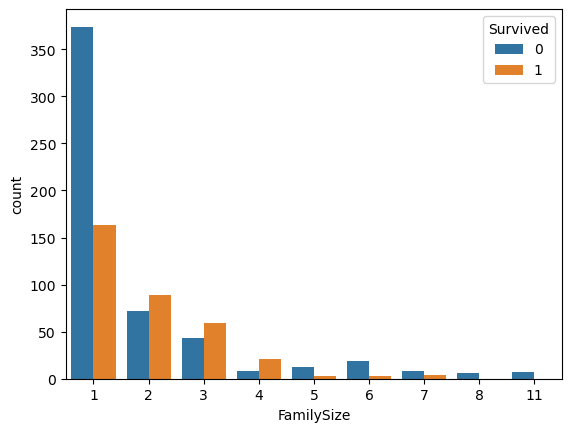

In [18]:
# 新しい特徴量を作成
# 状況: Parch、SipSpともに一定の値を超えると生存率が下がる
# 仮説: ParchとSipSpの両者を足し合わせて「家族の人数」という特徴量を新たに作ると、予測性能に寄与する可能性がある
import seaborn as sns

data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
train['FamilySize'] = data['FamilySize'][:len(train)]
test['FamilySize'] = data['FamilySize'][len(train):]
sns.countplot(x='FamilySize', data = train, hue='Survived')

FamilySize >= 5の場合、生存率が低い

FamilySize == 1の人が多く、かつ生存率が低い => 新しく特徴量を作成

In [19]:
data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1

train['IsAlone'] = data['IsAlone'][:len(train)]
test['IsAlone'] = data['IsAlone'][len(train):]

In [20]:
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
data.drop(delete_columns, axis=1, inplace=True)

train = data[:len(train)]
test = data[len(train):]

y_train = train['Survived']
X_train = train.drop('Survived', axis=1)
X_test = test.drop('Survived', axis=1)

In [21]:
X_train.head()

,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone
0,3,0,22.0,7.2500,0,2,0
1,1,1,38.0,71.2833,1,2,0
2,3,1,26.0,7.9250,0,1,1
3,1,1,35.0,53.1000,0,2,0
4,3,0,35.0,8.0500,0,1,1


## 予測性能の比較

In [22]:
sub = pd.read_csv('../input/titanic/gender_submission.csv')

In [23]:
clf.fit(X_train, y_train)
y_pred_familysize_isalone = clf.predict(X_test)

sub['Survived'] = list(map(int, y_pred_familysize_isalone))
sub.to_csv('submission_familysize_isalone.csv', index=False)

sub.head()

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [24]:
clf.fit(X_train.drop('FamilySize', axis=1), y_train)
y_pred_isalone = clf.predict(X_test.drop('FamilySize', axis=1))

sub['Survived'] = list(map(int, y_pred_isalone))
sub.to_csv('submission_isalone.csv', index=False)

sub.head()

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [25]:
clf.fit(X_train.drop('IsAlone', axis=1), y_train)
y_pred_familysize = clf.predict(X_test.drop('IsAlone', axis=1))

sub['Survived'] = list(map(int, y_pred_familysize))
sub.to_csv('submission_familysize.csv', index=False)

sub.head()

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [26]:
clf.fit(X_train.drop(['FamilySize', 'IsAlone'], axis=1), y_train)
y_pred = clf.predict(X_test.drop(['FamilySize', 'IsAlone'], axis=1))

sub['Survived'] = list(map(int, y_pred))
sub.to_csv('submission.csv', index=False)

sub.head()

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
